In [2]:
from typing import *
import os
from copy import deepcopy
from pathlib import Path
from datetime import datetime, date, timedelta
from collections import defaultdict
import pickle
import gc
import warnings

import numpy as np
import pandas as pd
import pandas_profiling as pdp
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from nptyping import NDArray, Shape, Int, Float
from rich import print as rprint
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import lightgbm as lgb
import optuna
# import optuna.integration.lightgbm as lgb
import shap


sns.set(font='Hiragino Sans', style='whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義
DATA_DIR = Path()/'data'
DF_DIR = DATA_DIR/'dataframes'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings('ignore')

def save_pkl(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [2]:
df_train: pd.DataFrame = pd.read_csv(DATA_DIR/'train.csv')
df_test: pd.DataFrame = pd.read_csv(DATA_DIR/'test.csv')
df_gender_submission: pd.DataFrame = pd.read_csv(DATA_DIR/'gender_submission.csv')

print(f'{df_train.shape = }')
print(f'{df_test.shape = }')
print(f'{df_gender_submission.shape = }')

df_train.shape = (891, 12)
df_test.shape = (418, 11)
df_gender_submission.shape = (418, 2)


In [7]:
profile: pdp.ProfileReport = pdp.ProfileReport(df_train)

display(profile)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## データ前処理

## 可視化

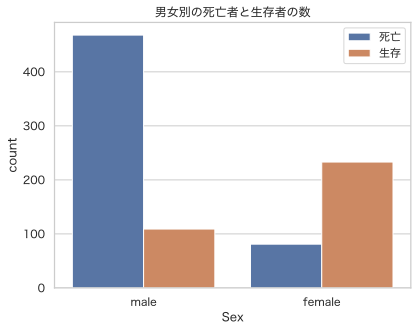

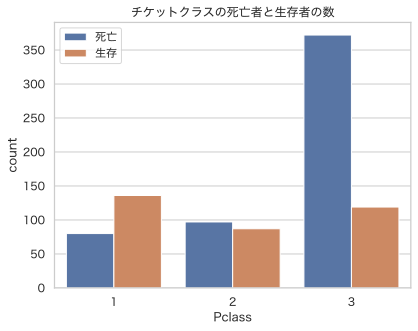

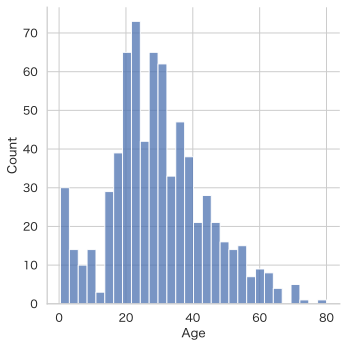

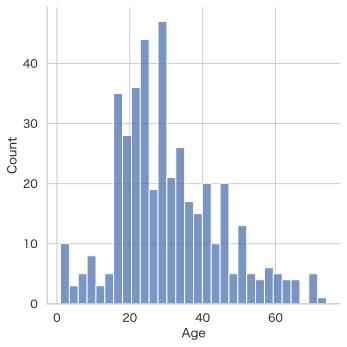

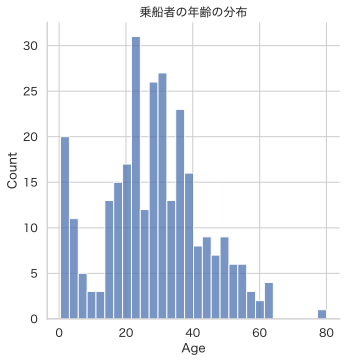

In [12]:
# 性別
sns.countplot(x='Sex', hue='Survived', data=df_train)
plt.title('男女別の死亡者と生存者の数')
plt.legend(['死亡', '生存'])
plt.show()

# チケットクラス
sns.countplot(x='Pclass', hue='Survived', data=df_train)
plt.title('チケットクラスの死亡者と生存者の数')
plt.legend(['死亡', '生存'])
plt.show()

# 年齢
sns.displot(df_train['Age'].dropna(), kde=False, bins=30, label='全体')
sns.displot(df_train[df_train['Survived'] == 0]['Age'].dropna(), kde=False, bins=30, label='死亡')
sns.displot(df_train[df_train['Survived'] == 1]['Age'].dropna(), kde=False, bins=30, label='生存')
plt.title('乗船者の年齢の分布')
plt.show()

## 学習

In [ ]:
import re
from typing import Tuple, Union, Dict, List, Optional

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


def split_cabin_str(s: str) -> Tuple[str, float]:
    """
    Function to try and extract cabin letter and number from the cabin column.
    Runs a regular expression that finds letters and numbers in the
    string. These are held in match.group, if they exist.
    """

    match = re.match(r"([a-z]+)([0-9]+)", s, re.I)

    letter = ''
    number = -1.0
    if match is not None:
        letter = match.group(1)
        number = match.group(2)

    return letter, number


def process_cabin(s: Union[str, float]) -> Tuple[str, float, int]:
    """From a cabin string, try and extract letter, number, and number of cabins."""
    # Check contents
    if not isinstance(s, str):
        # If field is empty, return nothing
        letter = ''
        number = ''
        n_rooms = -1.0
    else:
        # If field isn't empty, split sting on space. Some strings contain
        # multiple cabins.
        s = s.split(' ')
        # Count the cabins based on number of splits
        n_rooms = len(s)
        # Just take first cabin for letter/number extraction
        s = s[0]

        letter, number = split_cabin_str(s)

    return letter, number, n_rooms


def split_name_str(s: str, title_map: Dict[str, str]) -> Tuple[str, str]:
    """
    Extract title from name, replace with value in title dictionary and both title 
    and surname.
    """

    # Remove '.' from name string
    s = s.replace('.', '')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    # Get title - loop over title_map, if s matches a key, take the
    # corresponding value as the title
    title = [t for k, t in title_map.items() if str(k) in s]

    # If no matching keys in title dict, use 'Other'.
    if len(title) == 0:
        title = 'Other'
    else:
        # Title is a list, so extract contents
        title = title[0]

    # Return surname (stripping remaining ',') and title as string
    return surname.strip(','), title


In [102]:
def filter_sibsp(row: pd.Series) -> int:
    sibsp: int = row['SibSp']
    if sibsp in [0, 1]:
        return sibsp
    return 2

def filter_parch(row: pd.Series) -> int:
    parch: int = row['Parch']
    if parch in [0, 1, 2]:
        return parch
    return 3

def title_to_num(row: pd.Series) -> int:
    title: str = row['Title']
    if title == 'Master.':
        return 0
    elif title == 'Miss.':
        return 1
    elif title == 'Mr.':
        return 2
    elif title == 'Mrs.':
        return 3
    return 4

def encord_to_label(col: pd.Series) -> pd.Series:
    labels, _ = pd.factorize(col)
    return labels


df_train: pd.DataFrame = pd.read_csv(DATA_DIR/'train.csv')
df_test: pd.DataFrame = pd.read_csv(DATA_DIR/'test.csv')


def preprocess_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # df['SibSp_0_1_2over'] = df.swifter.apply(filter_sibsp, axis=1)
    # df['Parch_0_1_2_3over'] = df.swifter.apply(filter_parch, axis=1)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    # df['IsAlone'] = np.where(df['FamilySize'] > 1, 1, 0)
    df['Title'] = df['Name'].str.extract('([A-Za-z]+\.)', expand=False)
    df['Title'].replace(['Mlle.', 'Ms.'], 'Miss.', inplace=True)
    df['Title_num'] = df.swifter.apply(title_to_num, axis=1)
    df['TicketFreq'] = df.groupby(['Ticket'])['PassengerId'].transform('count')

    categories = ['Sex', 'Embarked']
    df[categories] = df[categories].swifter.apply(encord_to_label, axis=0)
    df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Title'], axis=1, inplace=True)
    return df


df_train = preprocess_dataset(df_train)
df_test = preprocess_dataset(df_test)
display(df_train.head())
display(df_test.head())

df_train.to_pickle(DF_DIR/'train.pkl')
df_test.to_pickle(DF_DIR/'test.pkl')

Pandas Apply:   0%|          | 0/891 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/418 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  Title_num  TicketFreq
0         0       3    0  22.0      1      0   7.2500         0           2          2           1
1         1       1    1  38.0      1      0  71.2833         1           2          3           1
2         1       3    1  26.0      0      0   7.9250         0           1          1           1
3         1       1    1  35.0      1      0  53.1000         0           2          3           2
4         0       3    0  35.0      0      0   8.0500         0           1          2           1

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  Title_num  TicketFreq
0       3    0  34.5      0      0   7.8292         0           1          2           1
1       3    1  47.0      1      0   7.0000         1           2          3           1
2       2    0  62.0      0      0   9.6875         0           1          2           1
3       3    0  27.0      0      0   8.6625         1           1          2           1
4       3    1  22.0      1      1  12.2875         1           3          3           1

In [71]:
class LGBMTrainer:
    def __init__(
            self,
            estimator: lgb.LGBMModel,
            matrics: List[Callable],
            df: pd.DataFrame, 
            target: str,
            features: Optional[List[str]] = None,
            use_shap: bool = False) -> None:
        self.estimator = estimator
        self.features: List[str] = df.drop(target, axis=1).columns if features is None else features
        self.X: NDArray[Shape['Sample, Features'], Float] = df[self.features].values
        self.y: NDArray[Shape['Sample'], Float] = df[target].values
        self.y_pred: NDArray[Shape['Sample'], Float] = np.zeros_like(self.y)
        self.models: List[lgb.LGBMModel] = []
        self.matrics: List[Callable] = matrics
        self.matrics_results: Dict[str, List[float]] = defaultdict(list)
        self.early_stopping_rounds = 100
        self.is_trained: bool = False
        self.use_shap: bool = use_shap
        self.shap_values_list = []
        self.val_indices_list = []

    def get_y_pred(self) -> pd.Series:
        if not self.is_trained:
            raise Exception('Untrained!')
        return pd.Series(self.y_pred)

    def get_matrics(self) -> pd.DataFrame:
        if not self.is_trained:
            raise Exception('Untrained!')
        return pd.DataFrame(self.matrics_results)

    def get_models(self) -> List[lgb.LGBMModel]:
        if not self.is_trained:
            raise Exception('Untrained!')
        return self.models

    def get_shap_values(self):
        if not self.use_shap:
            raise Exception('shap is not specified')
        if not self.is_trained:
            raise Exception('Untrained!')
        shap_values = np.concatenate(self.shap_values_list)
        val_indices = np.concatenate(self.val_indices_list)
        return shap_values, pd.DataFrame(self.X[val_indices], columns=self.features)
        
    def train(self, n_splits: int = 5):
        cv_indices = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(self.X, self.y)
        for nfold, (train_idx, val_idx) in enumerate(cv_indices):
            self._train_step(train_idx, val_idx)
            lgb.plot_metric(self.estimator)
            plt.savefig(f'loss_{nfold}.pdf')
        self.is_trained = True

    def _train_step(self, train_idx: List[int], val_idx: List[int]) -> None:
        X_train, y_train = self.X[train_idx], self.y[train_idx]
        X_val, y_val = self.X[val_idx], self.y[val_idx]
        self.estimator.fit(
            X=X_train, 
            y=y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)],
            early_stopping_rounds=self.early_stopping_rounds)
        y_train_pred = self.estimator.predict(X_train)
        y_val_pred = self.estimator.predict(X_val)
        for matric in self.matrics:
            self.matrics_results[f'train_{matric.__name__}'].append(matric(y_train, y_train_pred))
            self.matrics_results[f'val_{matric.__name__}'].append(matric(y_val, y_val_pred))
        self.matrics_results['best_iteration'].append(self.estimator.best_iteration_)
        self.y_pred[val_idx] = y_val_pred
        self.models.append(deepcopy(self.estimator))
        if self.use_shap:
            explainer = shap.TreeExplainer(self.estimator)
            shap_values = explainer.shap_values(X_val)[0]
            self.shap_values_list.append(shap_values)
            self.val_indices_list.append(val_idx)


In [68]:
# 最適化
import optuna
from sklearn.metrics import accuracy_score, log_loss

df_train: pd.DataFrame = pd.read_pickle(DF_DIR/'train.pkl')

target = 'Survived'

X: NDArray[Shape['Sample, Features'], Float] = df_train.drop(target, axis=1).values
y: NDArray[Shape['Sample'], Float] = df_train[target].values

def objective(trial):
    max_depth_limit = 10
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': 0.01,
        'num_leaves': trial.suggest_int('num_leaves', 2**6, 2**(max_depth_limit-1)),
        'max_depth': trial.suggest_int('max_depth', 6, max_depth_limit),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 40),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    }

    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=0)

    # LightGBMで学習+予測
    model = lgb.LGBMRegressor(**params, random_state=0)
    model.fit(X=X_tr, y=y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], early_stopping_rounds=100)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, np.rint(y_pred))
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

save_pkl(study.best_trial.params, path='best_params.pkl')

[I 2022-07-27 13:40:28,957] A new study created in memory with name: no-name-f68818c5-cc01-4307-b50f-57bad0a77fa3


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5708447933902611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5708447933902611
[LightGBM] [Warning] bagging_fraction is set=0.6826847820689864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826847820689864
[1]	training's binary_logloss: 0.660214	valid_1's binary_logloss: 0.662465
[2]	training's binary_logloss: 0.654181	valid_1's binary_logloss: 0.657507
[3]	training's binary_logloss: 0.650337	valid_1's binary_logloss: 0.655759
[4]	training's binary_logloss: 0.644806	valid_1's binary_logloss: 0.651571
[5]	training's binary_logloss: 0.639226	valid_1's binary_logloss: 0.64715
[6]	training's binary_logloss: 0.6357	valid_1's binary_logloss: 0.645142
[7]	training's binary_logloss: 0.63043	valid_1's binary_logloss: 0.641099
[8]	training's binary_logloss: 0.625209	valid_1's binary_l

[I 2022-07-27 13:40:30,928] Trial 0 finished with value: 0.8026905829596412 and parameters: {'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 8, 'bagging_fraction': 0.6826847820689864, 'feature_fraction': 0.5708447933902611}. Best is trial 0 with value: 0.8026905829596412.


[96]	training's binary_logloss: 0.384967	valid_1's binary_logloss: 0.479074
[97]	training's binary_logloss: 0.383181	valid_1's binary_logloss: 0.478259
[98]	training's binary_logloss: 0.381924	valid_1's binary_logloss: 0.477568
[99]	training's binary_logloss: 0.380525	valid_1's binary_logloss: 0.477679
[100]	training's binary_logloss: 0.379894	valid_1's binary_logloss: 0.47734
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.9995990381949361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995990381949361
[LightGBM] [Warning] bagging_fraction is set=0.5471282052552968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5471282052552968
[1]	training's binary_logloss: 0.660688	valid_1's binary_logloss: 0.662878
[2]	training's binary_logloss: 0.655859	valid_1's binary_logloss: 0.659079
[3]	training's binary_logloss: 0.651134	valid_1

[I 2022-07-27 13:40:31,455] Trial 1 finished with value: 0.7892376681614349 and parameters: {'num_leaves': 317, 'max_depth': 6, 'min_data_in_leaf': 26, 'bagging_fraction': 0.5471282052552968, 'feature_fraction': 0.9995990381949361}. Best is trial 0 with value: 0.8026905829596412.


[66]	training's binary_logloss: 0.478032	valid_1's binary_logloss: 0.525569
[67]	training's binary_logloss: 0.476456	valid_1's binary_logloss: 0.524559
[68]	training's binary_logloss: 0.474888	valid_1's binary_logloss: 0.523373
[69]	training's binary_logloss: 0.473348	valid_1's binary_logloss: 0.522138
[70]	training's binary_logloss: 0.471849	valid_1's binary_logloss: 0.521166
[71]	training's binary_logloss: 0.470348	valid_1's binary_logloss: 0.520042
[72]	training's binary_logloss: 0.468886	valid_1's binary_logloss: 0.519094
[73]	training's binary_logloss: 0.467428	valid_1's binary_logloss: 0.518037
[74]	training's binary_logloss: 0.466015	valid_1's binary_logloss: 0.517072
[75]	training's binary_logloss: 0.464393	valid_1's binary_logloss: 0.515679
[76]	training's binary_logloss: 0.462998	valid_1's binary_logloss: 0.514786
[77]	training's binary_logloss: 0.461428	valid_1's binary_logloss: 0.513693
[78]	training's binary_logloss: 0.459878	valid_1's binary_logloss: 0.512372
[79]	trainin

[I 2022-07-27 13:40:32,940] Trial 2 finished with value: 0.8071748878923767 and parameters: {'num_leaves': 148, 'max_depth': 7, 'min_data_in_leaf': 10, 'bagging_fraction': 0.6907513401420342, 'feature_fraction': 0.7066238276563831}. Best is trial 2 with value: 0.8071748878923767.


[100]	training's binary_logloss: 0.389452	valid_1's binary_logloss: 0.470645
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7472262872163505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7472262872163505
[LightGBM] [Warning] bagging_fraction is set=0.9094526520389787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9094526520389787
[1]	training's binary_logloss: 0.660845	valid_1's binary_logloss: 0.662644
[2]	training's binary_logloss: 0.656072	valid_1's binary_logloss: 0.658988
[3]	training's binary_logloss: 0.65154	valid_1's binary_logloss: 0.654964
[4]	training's binary_logloss: 0.647079	valid_1's binary_logloss: 0.651055
[5]	training's binary_logloss: 0.642951	valid_1's binary_logloss: 0.647725
[6]	training's binary_logloss: 0.640394	valid_1's binary_logloss: 0.64579
[7]	training's binary_logloss: 0.635951	valid_1's bi

[I 2022-07-27 13:40:33,605] Trial 3 finished with value: 0.7937219730941704 and parameters: {'num_leaves': 105, 'max_depth': 7, 'min_data_in_leaf': 28, 'bagging_fraction': 0.9094526520389787, 'feature_fraction': 0.7472262872163505}. Best is trial 2 with value: 0.8071748878923767.


[92]	training's binary_logloss: 0.445609	valid_1's binary_logloss: 0.493694
[93]	training's binary_logloss: 0.444405	valid_1's binary_logloss: 0.493046
[94]	training's binary_logloss: 0.443131	valid_1's binary_logloss: 0.491832
[95]	training's binary_logloss: 0.441912	valid_1's binary_logloss: 0.491124
[96]	training's binary_logloss: 0.440694	valid_1's binary_logloss: 0.490382
[97]	training's binary_logloss: 0.439461	valid_1's binary_logloss: 0.489238
[98]	training's binary_logloss: 0.438306	valid_1's binary_logloss: 0.488113
[99]	training's binary_logloss: 0.437337	valid_1's binary_logloss: 0.487485
[100]	training's binary_logloss: 0.436622	valid_1's binary_logloss: 0.486964
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8359993191425855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8359993191425855
[LightGBM] [Warning] bagging_fraction i

[I 2022-07-27 13:40:34,566] Trial 4 finished with value: 0.8161434977578476 and parameters: {'num_leaves': 367, 'max_depth': 6, 'min_data_in_leaf': 12, 'bagging_fraction': 0.7758665476584823, 'feature_fraction': 0.8359993191425855}. Best is trial 4 with value: 0.8161434977578476.


[82]	training's binary_logloss: 0.422214	valid_1's binary_logloss: 0.485317
[83]	training's binary_logloss: 0.42064	valid_1's binary_logloss: 0.484269
[84]	training's binary_logloss: 0.419116	valid_1's binary_logloss: 0.483271
[85]	training's binary_logloss: 0.417564	valid_1's binary_logloss: 0.482237
[86]	training's binary_logloss: 0.416108	valid_1's binary_logloss: 0.481375
[87]	training's binary_logloss: 0.414662	valid_1's binary_logloss: 0.48059
[88]	training's binary_logloss: 0.413187	valid_1's binary_logloss: 0.479691
[89]	training's binary_logloss: 0.411576	valid_1's binary_logloss: 0.478745
[90]	training's binary_logloss: 0.410114	valid_1's binary_logloss: 0.477789
[91]	training's binary_logloss: 0.408687	valid_1's binary_logloss: 0.47688
[92]	training's binary_logloss: 0.407209	valid_1's binary_logloss: 0.476018
[93]	training's binary_logloss: 0.405829	valid_1's binary_logloss: 0.475192
[94]	training's binary_logloss: 0.40449	valid_1's binary_logloss: 0.474393
[95]	training's 

[I 2022-07-27 13:40:35,101] Trial 5 finished with value: 0.7847533632286996 and parameters: {'num_leaves': 294, 'max_depth': 6, 'min_data_in_leaf': 37, 'bagging_fraction': 0.5491254430808069, 'feature_fraction': 0.7107703818880551}. Best is trial 4 with value: 0.8161434977578476.


[79]	training's binary_logloss: 0.475202	valid_1's binary_logloss: 0.513216
[80]	training's binary_logloss: 0.473755	valid_1's binary_logloss: 0.512051
[81]	training's binary_logloss: 0.472437	valid_1's binary_logloss: 0.511196
[82]	training's binary_logloss: 0.471127	valid_1's binary_logloss: 0.510361
[83]	training's binary_logloss: 0.469738	valid_1's binary_logloss: 0.509253
[84]	training's binary_logloss: 0.468331	valid_1's binary_logloss: 0.507939
[85]	training's binary_logloss: 0.467034	valid_1's binary_logloss: 0.506784
[86]	training's binary_logloss: 0.465729	valid_1's binary_logloss: 0.506001
[87]	training's binary_logloss: 0.46437	valid_1's binary_logloss: 0.50512
[88]	training's binary_logloss: 0.463042	valid_1's binary_logloss: 0.50422
[89]	training's binary_logloss: 0.461845	valid_1's binary_logloss: 0.503528
[90]	training's binary_logloss: 0.460631	valid_1's binary_logloss: 0.502451
[91]	training's binary_logloss: 0.45935	valid_1's binary_logloss: 0.501473
[92]	training's 

[I 2022-07-27 13:40:36,081] Trial 6 finished with value: 0.7982062780269058 and parameters: {'num_leaves': 281, 'max_depth': 10, 'min_data_in_leaf': 20, 'bagging_fraction': 0.7937264950476179, 'feature_fraction': 0.650449569571276}. Best is trial 4 with value: 0.8161434977578476.


[93]	training's binary_logloss: 0.430426	valid_1's binary_logloss: 0.491553
[94]	training's binary_logloss: 0.429023	valid_1's binary_logloss: 0.490525
[95]	training's binary_logloss: 0.427787	valid_1's binary_logloss: 0.489856
[96]	training's binary_logloss: 0.426453	valid_1's binary_logloss: 0.489247
[97]	training's binary_logloss: 0.42499	valid_1's binary_logloss: 0.488223
[98]	training's binary_logloss: 0.423717	valid_1's binary_logloss: 0.487434
[99]	training's binary_logloss: 0.422598	valid_1's binary_logloss: 0.487004
[100]	training's binary_logloss: 0.421767	valid_1's binary_logloss: 0.486496
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5832296533759413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5832296533759413
[LightGBM] [Warning] bagging_fraction is set=0.8015529902496201, subsample=1.0 will be ignored. Current value: baggi

[I 2022-07-27 13:40:36,649] Trial 7 finished with value: 0.7892376681614349 and parameters: {'num_leaves': 323, 'max_depth': 7, 'min_data_in_leaf': 39, 'bagging_fraction': 0.8015529902496201, 'feature_fraction': 0.5832296533759413}. Best is trial 4 with value: 0.8161434977578476.


[96]	training's binary_logloss: 0.463774	valid_1's binary_logloss: 0.50423
[97]	training's binary_logloss: 0.462706	valid_1's binary_logloss: 0.503373
[98]	training's binary_logloss: 0.461516	valid_1's binary_logloss: 0.502198
[99]	training's binary_logloss: 0.460565	valid_1's binary_logloss: 0.501563
[100]	training's binary_logloss: 0.45993	valid_1's binary_logloss: 0.501013
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.7478338040321069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7478338040321069
[LightGBM] [Warning] bagging_fraction is set=0.8608296433237552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8608296433237552
[1]	training's binary_logloss: 0.660261	valid_1's binary_logloss: 0.662497
[2]	training's binary_logloss: 0.654687	valid_1's binary_logloss: 0.658219
[3]	training's binary_logloss: 0.649641	valid_1'

[I 2022-07-27 13:40:37,853] Trial 8 finished with value: 0.7937219730941704 and parameters: {'num_leaves': 221, 'max_depth': 7, 'min_data_in_leaf': 16, 'bagging_fraction': 0.8608296433237552, 'feature_fraction': 0.7478338040321069}. Best is trial 4 with value: 0.8161434977578476.


[81]	training's binary_logloss: 0.432961	valid_1's binary_logloss: 0.495604
[82]	training's binary_logloss: 0.431255	valid_1's binary_logloss: 0.494501
[83]	training's binary_logloss: 0.429674	valid_1's binary_logloss: 0.493524
[84]	training's binary_logloss: 0.428074	valid_1's binary_logloss: 0.49265
[85]	training's binary_logloss: 0.426532	valid_1's binary_logloss: 0.491484
[86]	training's binary_logloss: 0.425035	valid_1's binary_logloss: 0.49065
[87]	training's binary_logloss: 0.423412	valid_1's binary_logloss: 0.490016
[88]	training's binary_logloss: 0.421811	valid_1's binary_logloss: 0.489382
[89]	training's binary_logloss: 0.420206	valid_1's binary_logloss: 0.488425
[90]	training's binary_logloss: 0.418756	valid_1's binary_logloss: 0.487344
[91]	training's binary_logloss: 0.417377	valid_1's binary_logloss: 0.486522
[92]	training's binary_logloss: 0.416086	valid_1's binary_logloss: 0.485737
[93]	training's binary_logloss: 0.414722	valid_1's binary_logloss: 0.485005
[94]	training'

[I 2022-07-27 13:40:38,757] Trial 9 finished with value: 0.7982062780269058 and parameters: {'num_leaves': 219, 'max_depth': 10, 'min_data_in_leaf': 20, 'bagging_fraction': 0.7294718102372704, 'feature_fraction': 0.7326769396739781}. Best is trial 4 with value: 0.8161434977578476.


[93]	training's binary_logloss: 0.430426	valid_1's binary_logloss: 0.491553
[94]	training's binary_logloss: 0.429023	valid_1's binary_logloss: 0.490525
[95]	training's binary_logloss: 0.427787	valid_1's binary_logloss: 0.489856
[96]	training's binary_logloss: 0.426453	valid_1's binary_logloss: 0.489247
[97]	training's binary_logloss: 0.42499	valid_1's binary_logloss: 0.488223
[98]	training's binary_logloss: 0.423717	valid_1's binary_logloss: 0.487434
[99]	training's binary_logloss: 0.422598	valid_1's binary_logloss: 0.487004
[100]	training's binary_logloss: 0.421767	valid_1's binary_logloss: 0.486496
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.8908439129829394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8908439129829394
[LightGBM] [Warning] bagging_fraction is set=0.9413420369902349, subsample=1.0 will be ignored. Current value: baggi

[I 2022-07-27 13:40:40,024] Trial 10 finished with value: 0.8071748878923767 and parameters: {'num_leaves': 483, 'max_depth': 9, 'min_data_in_leaf': 14, 'bagging_fraction': 0.9413420369902349, 'feature_fraction': 0.8908439129829394}. Best is trial 4 with value: 0.8161434977578476.


[93]	training's binary_logloss: 0.394952	valid_1's binary_logloss: 0.483592
[94]	training's binary_logloss: 0.393459	valid_1's binary_logloss: 0.482838
[95]	training's binary_logloss: 0.392145	valid_1's binary_logloss: 0.482127
[96]	training's binary_logloss: 0.39079	valid_1's binary_logloss: 0.4816
[97]	training's binary_logloss: 0.389447	valid_1's binary_logloss: 0.480812
[98]	training's binary_logloss: 0.388122	valid_1's binary_logloss: 0.480041
[99]	training's binary_logloss: 0.386802	valid_1's binary_logloss: 0.479411
[100]	training's binary_logloss: 0.385513	valid_1's binary_logloss: 0.478675
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.8548331021482688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8548331021482688
[LightGBM] [Warning] bagging_fraction is set=0.6571709173961713, subsample=1.0 will be ignored. Current value: bagging_f

[I 2022-07-27 13:40:42,192] Trial 11 finished with value: 0.820627802690583 and parameters: {'num_leaves': 430, 'max_depth': 8, 'min_data_in_leaf': 6, 'bagging_fraction': 0.6571709173961713, 'feature_fraction': 0.8548331021482688}. Best is trial 11 with value: 0.820627802690583.


[93]	training's binary_logloss: 0.3679	valid_1's binary_logloss: 0.471393
[94]	training's binary_logloss: 0.366299	valid_1's binary_logloss: 0.470834
[95]	training's binary_logloss: 0.364745	valid_1's binary_logloss: 0.47016
[96]	training's binary_logloss: 0.363175	valid_1's binary_logloss: 0.469369
[97]	training's binary_logloss: 0.361333	valid_1's binary_logloss: 0.468466
[98]	training's binary_logloss: 0.359517	valid_1's binary_logloss: 0.467586
[99]	training's binary_logloss: 0.358017	valid_1's binary_logloss: 0.466819
[100]	training's binary_logloss: 0.356597	valid_1's binary_logloss: 0.466139
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8598008450560025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598008450560025
[LightGBM] [Warning] bagging_fraction is set=0.6256711922313944, subsample=1.0 will be ignored. Current value: bagging_f

[I 2022-07-27 13:40:44,685] Trial 12 finished with value: 0.8340807174887892 and parameters: {'num_leaves': 446, 'max_depth': 8, 'min_data_in_leaf': 5, 'bagging_fraction': 0.6256711922313944, 'feature_fraction': 0.8598008450560025}. Best is trial 12 with value: 0.8340807174887892.


[96]	training's binary_logloss: 0.357272	valid_1's binary_logloss: 0.46641
[97]	training's binary_logloss: 0.355445	valid_1's binary_logloss: 0.465606
[98]	training's binary_logloss: 0.35363	valid_1's binary_logloss: 0.464843
[99]	training's binary_logloss: 0.351852	valid_1's binary_logloss: 0.464237
[100]	training's binary_logloss: 0.350445	valid_1's binary_logloss: 0.46339
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.8636392487887982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636392487887982
[LightGBM] [Warning] bagging_fraction is set=0.6207061411255991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6207061411255991
[1]	training's binary_logloss: 0.659618	valid_1's binary_logloss: 0.662216
[2]	training's binary_logloss: 0.653325	valid_1's binary_logloss: 0.65769
[3]	training's binary_logloss: 0.647425	valid_1's bi

[I 2022-07-27 13:40:46,586] Trial 13 finished with value: 0.820627802690583 and parameters: {'num_leaves': 472, 'max_depth': 8, 'min_data_in_leaf': 6, 'bagging_fraction': 0.6207061411255991, 'feature_fraction': 0.8636392487887982}. Best is trial 12 with value: 0.8340807174887892.


[96]	training's binary_logloss: 0.363175	valid_1's binary_logloss: 0.469369
[97]	training's binary_logloss: 0.361333	valid_1's binary_logloss: 0.468466
[98]	training's binary_logloss: 0.359517	valid_1's binary_logloss: 0.467586
[99]	training's binary_logloss: 0.358017	valid_1's binary_logloss: 0.466819
[100]	training's binary_logloss: 0.356597	valid_1's binary_logloss: 0.466139
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.9502821123514811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9502821123514811
[LightGBM] [Warning] bagging_fraction is set=0.6239847653275824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6239847653275824
[1]	training's binary_logloss: 0.659046	valid_1's binary_logloss: 0.661798
[2]	training's binary_logloss: 0.652611	valid_1's binary_logloss: 0.657022
[3]	training's binary_logloss: 0.646316	valid_1'

[I 2022-07-27 13:40:49,185] Trial 14 finished with value: 0.8385650224215246 and parameters: {'num_leaves': 415, 'max_depth': 8, 'min_data_in_leaf': 5, 'bagging_fraction': 0.6239847653275824, 'feature_fraction': 0.9502821123514811}. Best is trial 14 with value: 0.8385650224215246.


[100]	training's binary_logloss: 0.351092	valid_1's binary_logloss: 0.469723
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.975983810972988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975983810972988
[LightGBM] [Warning] bagging_fraction is set=0.603065455426715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.603065455426715
[1]	training's binary_logloss: 0.65892	valid_1's binary_logloss: 0.661718
[2]	training's binary_logloss: 0.652357	valid_1's binary_logloss: 0.656882
[3]	training's binary_logloss: 0.64594	valid_1's binary_logloss: 0.652074
[4]	training's binary_logloss: 0.639678	valid_1's binary_logloss: 0.647387
[5]	training's binary_logloss: 0.633552	valid_1's binary_logloss: 0.642761
[6]	training's binary_logloss: 0.627549	valid_1's binary_logloss: 0.638343
[7]	training's binary_logloss: 0.621673	valid_1's binary_l

[I 2022-07-27 13:40:51,890] Trial 15 finished with value: 0.8385650224215246 and parameters: {'num_leaves': 397, 'max_depth': 9, 'min_data_in_leaf': 5, 'bagging_fraction': 0.603065455426715, 'feature_fraction': 0.975983810972988}. Best is trial 14 with value: 0.8385650224215246.


[96]	training's binary_logloss: 0.344123	valid_1's binary_logloss: 0.468875
[97]	training's binary_logloss: 0.342415	valid_1's binary_logloss: 0.468859
[98]	training's binary_logloss: 0.340686	valid_1's binary_logloss: 0.468677
[99]	training's binary_logloss: 0.338962	valid_1's binary_logloss: 0.468619
[100]	training's binary_logloss: 0.337359	valid_1's binary_logloss: 0.468283
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9835711292577377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835711292577377
[LightGBM] [Warning] bagging_fraction is set=0.5165234895336377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5165234895336377
[1]	training's binary_logloss: 0.660756	valid_1's binary_logloss: 0.66304
[2]	training's binary_logloss: 0.655994	valid_1's binary_logloss: 0.659388
[3]	training's binary_logloss: 0.65129	valid_1'

[I 2022-07-27 13:40:52,488] Trial 16 finished with value: 0.7892376681614349 and parameters: {'num_leaves': 388, 'max_depth': 9, 'min_data_in_leaf': 30, 'bagging_fraction': 0.5165234895336377, 'feature_fraction': 0.9835711292577377}. Best is trial 14 with value: 0.8385650224215246.


[86]	training's binary_logloss: 0.452424	valid_1's binary_logloss: 0.507705
[87]	training's binary_logloss: 0.451241	valid_1's binary_logloss: 0.506837
[88]	training's binary_logloss: 0.450039	valid_1's binary_logloss: 0.50611
[89]	training's binary_logloss: 0.448892	valid_1's binary_logloss: 0.505384
[90]	training's binary_logloss: 0.447581	valid_1's binary_logloss: 0.504404
[91]	training's binary_logloss: 0.446426	valid_1's binary_logloss: 0.503715
[92]	training's binary_logloss: 0.445159	valid_1's binary_logloss: 0.502899
[93]	training's binary_logloss: 0.443893	valid_1's binary_logloss: 0.502066
[94]	training's binary_logloss: 0.442816	valid_1's binary_logloss: 0.501299
[95]	training's binary_logloss: 0.4416	valid_1's binary_logloss: 0.500529
[96]	training's binary_logloss: 0.440385	valid_1's binary_logloss: 0.499735
[97]	training's binary_logloss: 0.439321	valid_1's binary_logloss: 0.499081
[98]	training's binary_logloss: 0.438145	valid_1's binary_logloss: 0.498358
[99]	training's

[I 2022-07-27 13:40:53,736] Trial 17 finished with value: 0.7982062780269058 and parameters: {'num_leaves': 398, 'max_depth': 9, 'min_data_in_leaf': 16, 'bagging_fraction': 0.5977453012006229, 'feature_fraction': 0.9440761324367964}. Best is trial 14 with value: 0.8385650224215246.


[94]	training's binary_logloss: 0.402327	valid_1's binary_logloss: 0.482236
[95]	training's binary_logloss: 0.401042	valid_1's binary_logloss: 0.481503
[96]	training's binary_logloss: 0.39969	valid_1's binary_logloss: 0.480893
[97]	training's binary_logloss: 0.398368	valid_1's binary_logloss: 0.480029
[98]	training's binary_logloss: 0.397065	valid_1's binary_logloss: 0.479183
[99]	training's binary_logloss: 0.395734	valid_1's binary_logloss: 0.478554
[100]	training's binary_logloss: 0.394523	valid_1's binary_logloss: 0.477997
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9205721362795676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9205721362795676
[LightGBM] [Warning] bagging_fraction is set=0.5732633801052056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5732633801052056
[1]	training's binary_logloss: 0.659972	valid

[I 2022-07-27 13:40:55,622] Trial 18 finished with value: 0.8251121076233184 and parameters: {'num_leaves': 511, 'max_depth': 9, 'min_data_in_leaf': 10, 'bagging_fraction': 0.5732633801052056, 'feature_fraction': 0.9205721362795676}. Best is trial 14 with value: 0.8385650224215246.


[96]	training's binary_logloss: 0.378764	valid_1's binary_logloss: 0.470813
[97]	training's binary_logloss: 0.377351	valid_1's binary_logloss: 0.469975
[98]	training's binary_logloss: 0.375959	valid_1's binary_logloss: 0.469155
[99]	training's binary_logloss: 0.374491	valid_1's binary_logloss: 0.468468
[100]	training's binary_logloss: 0.373218	valid_1's binary_logloss: 0.46783
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.818404238723182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.818404238723182
[LightGBM] [Warning] bagging_fraction is set=0.5037831314574374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037831314574374
[1]	training's binary_logloss: 0.660815	valid_1's binary_logloss: 0.662846
[2]	training's binary_logloss: 0.655881	valid_1's binary_logloss: 0.658991
[3]	training's binary_logloss: 0.651246	valid_1's

[I 2022-07-27 13:40:56,581] Trial 19 finished with value: 0.7892376681614349 and parameters: {'num_leaves': 354, 'max_depth': 9, 'min_data_in_leaf': 23, 'bagging_fraction': 0.5037831314574374, 'feature_fraction': 0.818404238723182}. Best is trial 14 with value: 0.8385650224215246.


[98]	training's binary_logloss: 0.427959	valid_1's binary_logloss: 0.486491
[99]	training's binary_logloss: 0.426771	valid_1's binary_logloss: 0.486124
[100]	training's binary_logloss: 0.425571	valid_1's binary_logloss: 0.485704
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9465211261398963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9465211261398963
[LightGBM] [Warning] bagging_fraction is set=0.7010110447612454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7010110447612454
[1]	training's binary_logloss: 0.661054	valid_1's binary_logloss: 0.662826
[2]	training's binary_logloss: 0.656463	valid_1's binary_logloss: 0.659156
[3]	training's binary_logloss: 0.652054	valid_1's binary_logloss: 0.655579
[4]	training's binary_logloss: 0.647676	valid_1's binary_logloss: 0.652191
[5]	training's binary_logloss: 0.643392	valid_1'

[I 2022-07-27 13:40:57,116] Trial 20 finished with value: 0.7847533632286996 and parameters: {'num_leaves': 252, 'max_depth': 8, 'min_data_in_leaf': 34, 'bagging_fraction': 0.7010110447612454, 'feature_fraction': 0.9465211261398963}. Best is trial 14 with value: 0.8385650224215246.


[71]	training's binary_logloss: 0.474783	valid_1's binary_logloss: 0.522031
[72]	training's binary_logloss: 0.473241	valid_1's binary_logloss: 0.521143
[73]	training's binary_logloss: 0.471723	valid_1's binary_logloss: 0.520281
[74]	training's binary_logloss: 0.470284	valid_1's binary_logloss: 0.518951
[75]	training's binary_logloss: 0.468878	valid_1's binary_logloss: 0.518024
[76]	training's binary_logloss: 0.467481	valid_1's binary_logloss: 0.517142
[77]	training's binary_logloss: 0.466086	valid_1's binary_logloss: 0.516296
[78]	training's binary_logloss: 0.464741	valid_1's binary_logloss: 0.51541
[79]	training's binary_logloss: 0.463399	valid_1's binary_logloss: 0.514173
[80]	training's binary_logloss: 0.462033	valid_1's binary_logloss: 0.513391
[81]	training's binary_logloss: 0.460688	valid_1's binary_logloss: 0.512627
[82]	training's binary_logloss: 0.459403	valid_1's binary_logloss: 0.511761
[83]	training's binary_logloss: 0.458141	valid_1's binary_logloss: 0.510999
[84]	training

[I 2022-07-27 13:40:59,154] Trial 21 finished with value: 0.8430493273542601 and parameters: {'num_leaves': 435, 'max_depth': 8, 'min_data_in_leaf': 5, 'bagging_fraction': 0.6329460527588094, 'feature_fraction': 0.8026870065713427}. Best is trial 21 with value: 0.8430493273542601.


[97]	training's binary_logloss: 0.35774	valid_1's binary_logloss: 0.462472
[98]	training's binary_logloss: 0.356108	valid_1's binary_logloss: 0.461709
[99]	training's binary_logloss: 0.354434	valid_1's binary_logloss: 0.461424
[100]	training's binary_logloss: 0.352926	valid_1's binary_logloss: 0.460646
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.7925293548623769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925293548623769
[LightGBM] [Warning] bagging_fraction is set=0.6246159013215895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6246159013215895
[1]	training's binary_logloss: 0.659857	valid_1's binary_logloss: 0.662151
[2]	training's binary_logloss: 0.6538	valid_1's binary_logloss: 0.657533
[3]	training's binary_logloss: 0.648123	valid_1's binary_logloss: 0.652733
[4]	training's binary_logloss: 0.642754	valid_1's bi

[I 2022-07-27 13:41:00,721] Trial 22 finished with value: 0.8161434977578476 and parameters: {'num_leaves': 413, 'max_depth': 8, 'min_data_in_leaf': 9, 'bagging_fraction': 0.6246159013215895, 'feature_fraction': 0.7925293548623769}. Best is trial 21 with value: 0.8430493273542601.


[89]	training's binary_logloss: 0.389997	valid_1's binary_logloss: 0.475824
[90]	training's binary_logloss: 0.388427	valid_1's binary_logloss: 0.474958
[91]	training's binary_logloss: 0.386873	valid_1's binary_logloss: 0.474079
[92]	training's binary_logloss: 0.385366	valid_1's binary_logloss: 0.47329
[93]	training's binary_logloss: 0.383691	valid_1's binary_logloss: 0.472374
[94]	training's binary_logloss: 0.382086	valid_1's binary_logloss: 0.471684
[95]	training's binary_logloss: 0.380634	valid_1's binary_logloss: 0.470817
[96]	training's binary_logloss: 0.379242	valid_1's binary_logloss: 0.47007
[97]	training's binary_logloss: 0.377792	valid_1's binary_logloss: 0.469255
[98]	training's binary_logloss: 0.376455	valid_1's binary_logloss: 0.468467
[99]	training's binary_logloss: 0.374895	valid_1's binary_logloss: 0.467708
[100]	training's binary_logloss: 0.373554	valid_1's binary_logloss: 0.467082
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cur

[I 2022-07-27 13:41:04,114] Trial 23 finished with value: 0.8385650224215246 and parameters: {'num_leaves': 466, 'max_depth': 9, 'min_data_in_leaf': 5, 'bagging_fraction': 0.6532199340068419, 'feature_fraction': 0.9159319182521175}. Best is trial 21 with value: 0.8430493273542601.


[94]	training's binary_logloss: 0.350464	valid_1's binary_logloss: 0.463844
[95]	training's binary_logloss: 0.348818	valid_1's binary_logloss: 0.463218
[96]	training's binary_logloss: 0.347006	valid_1's binary_logloss: 0.462755
[97]	training's binary_logloss: 0.345166	valid_1's binary_logloss: 0.461774
[98]	training's binary_logloss: 0.343243	valid_1's binary_logloss: 0.461046
[99]	training's binary_logloss: 0.341458	valid_1's binary_logloss: 0.460866
[100]	training's binary_logloss: 0.339996	valid_1's binary_logloss: 0.460143
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.7952170501584409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7952170501584409
[LightGBM] [Warning] bagging_fraction is set=0.6604773710612435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6604773710612435
[1]	training's binary_logloss: 0.660124	vali

[I 2022-07-27 13:41:05,501] Trial 24 finished with value: 0.8116591928251121 and parameters: {'num_leaves': 469, 'max_depth': 9, 'min_data_in_leaf': 13, 'bagging_fraction': 0.6604773710612435, 'feature_fraction': 0.7952170501584409}. Best is trial 21 with value: 0.8430493273542601.


[97]	training's binary_logloss: 0.390218	valid_1's binary_logloss: 0.475715
[98]	training's binary_logloss: 0.3889	valid_1's binary_logloss: 0.474845
[99]	training's binary_logloss: 0.387489	valid_1's binary_logloss: 0.474376
[100]	training's binary_logloss: 0.386251	valid_1's binary_logloss: 0.473733
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.9665202053285895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9665202053285895
[LightGBM] [Warning] bagging_fraction is set=0.9998661539264453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998661539264453
[1]	training's binary_logloss: 0.659386	valid_1's binary_logloss: 0.66199
[2]	training's binary_logloss: 0.653282	valid_1's binary_logloss: 0.657347
[3]	training's binary_logloss: 0.64731	valid_1's binary_logloss: 0.652856
[4]	training's binary_logloss: 0.64145	valid_1's bina

[I 2022-07-27 13:41:07,028] Trial 25 finished with value: 0.8251121076233184 and parameters: {'num_leaves': 353, 'max_depth': 8, 'min_data_in_leaf': 8, 'bagging_fraction': 0.9998661539264453, 'feature_fraction': 0.9665202053285895}. Best is trial 21 with value: 0.8430493273542601.


[89]	training's binary_logloss: 0.383981	valid_1's binary_logloss: 0.48062
[90]	training's binary_logloss: 0.382395	valid_1's binary_logloss: 0.480084
[91]	training's binary_logloss: 0.380844	valid_1's binary_logloss: 0.479358
[92]	training's binary_logloss: 0.37928	valid_1's binary_logloss: 0.478869
[93]	training's binary_logloss: 0.37773	valid_1's binary_logloss: 0.478228
[94]	training's binary_logloss: 0.376226	valid_1's binary_logloss: 0.477527
[95]	training's binary_logloss: 0.374709	valid_1's binary_logloss: 0.477024
[96]	training's binary_logloss: 0.373228	valid_1's binary_logloss: 0.476329
[97]	training's binary_logloss: 0.371793	valid_1's binary_logloss: 0.475814
[98]	training's binary_logloss: 0.370351	valid_1's binary_logloss: 0.475351
[99]	training's binary_logloss: 0.368935	valid_1's binary_logloss: 0.474497
[100]	training's binary_logloss: 0.367509	valid_1's binary_logloss: 0.473754
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Cur

[I 2022-07-27 13:41:08,474] Trial 26 finished with value: 0.8026905829596412 and parameters: {'num_leaves': 510, 'max_depth': 10, 'min_data_in_leaf': 17, 'bagging_fraction': 0.7524868143665476, 'feature_fraction': 0.9075043871253105}. Best is trial 21 with value: 0.8430493273542601.


[89]	training's binary_logloss: 0.42317	valid_1's binary_logloss: 0.494607
[90]	training's binary_logloss: 0.421563	valid_1's binary_logloss: 0.493156
[91]	training's binary_logloss: 0.419954	valid_1's binary_logloss: 0.492466
[92]	training's binary_logloss: 0.418151	valid_1's binary_logloss: 0.491726
[93]	training's binary_logloss: 0.41674	valid_1's binary_logloss: 0.491094
[94]	training's binary_logloss: 0.415391	valid_1's binary_logloss: 0.490627
[95]	training's binary_logloss: 0.413858	valid_1's binary_logloss: 0.489997
[96]	training's binary_logloss: 0.412166	valid_1's binary_logloss: 0.489287
[97]	training's binary_logloss: 0.410685	valid_1's binary_logloss: 0.487943
[98]	training's binary_logloss: 0.409225	valid_1's binary_logloss: 0.486623
[99]	training's binary_logloss: 0.407632	valid_1's binary_logloss: 0.485979
[100]	training's binary_logloss: 0.406163	valid_1's binary_logloss: 0.485272
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Cu

[I 2022-07-27 13:41:10,053] Trial 27 finished with value: 0.8161434977578476 and parameters: {'num_leaves': 447, 'max_depth': 9, 'min_data_in_leaf': 12, 'bagging_fraction': 0.5811941044393301, 'feature_fraction': 0.8976453121139646}. Best is trial 21 with value: 0.8430493273542601.


[96]	training's binary_logloss: 0.386426	valid_1's binary_logloss: 0.476866
[97]	training's binary_logloss: 0.385002	valid_1's binary_logloss: 0.475974
[98]	training's binary_logloss: 0.383597	valid_1's binary_logloss: 0.475101
[99]	training's binary_logloss: 0.382241	valid_1's binary_logloss: 0.47461
[100]	training's binary_logloss: 0.38088	valid_1's binary_logloss: 0.473873
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.514792392633852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514792392633852
[LightGBM] [Warning] bagging_fraction is set=0.6673119442819381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6673119442819381
[1]	training's binary_logloss: 0.660417	valid_1's binary_logloss: 0.662329
[2]	training's binary_logloss: 0.654272	valid_1's binary_logloss: 0.657177
[3]	training's binary_logloss: 0.650692	valid_1's bi

[I 2022-07-27 13:41:12,366] Trial 28 finished with value: 0.8026905829596412 and parameters: {'num_leaves': 449, 'max_depth': 9, 'min_data_in_leaf': 8, 'bagging_fraction': 0.6673119442819381, 'feature_fraction': 0.514792392633852}. Best is trial 21 with value: 0.8430493273542601.


[90]	training's binary_logloss: 0.412637	valid_1's binary_logloss: 0.490445
[91]	training's binary_logloss: 0.411024	valid_1's binary_logloss: 0.489435
[92]	training's binary_logloss: 0.409617	valid_1's binary_logloss: 0.488272
[93]	training's binary_logloss: 0.408648	valid_1's binary_logloss: 0.487937
[94]	training's binary_logloss: 0.406601	valid_1's binary_logloss: 0.486644
[95]	training's binary_logloss: 0.404842	valid_1's binary_logloss: 0.485684
[96]	training's binary_logloss: 0.402963	valid_1's binary_logloss: 0.484331
[97]	training's binary_logloss: 0.400976	valid_1's binary_logloss: 0.483179
[98]	training's binary_logloss: 0.399537	valid_1's binary_logloss: 0.482357
[99]	training's binary_logloss: 0.398512	valid_1's binary_logloss: 0.482215
[100]	training's binary_logloss: 0.397962	valid_1's binary_logloss: 0.481783
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is se

[I 2022-07-27 13:41:14,297] Trial 29 finished with value: 0.8161434977578476 and parameters: {'num_leaves': 419, 'max_depth': 8, 'min_data_in_leaf': 8, 'bagging_fraction': 0.7162698693557352, 'feature_fraction': 0.6704422279822314}. Best is trial 21 with value: 0.8430493273542601.


[98]	training's binary_logloss: 0.377498	valid_1's binary_logloss: 0.469961
[99]	training's binary_logloss: 0.37617	valid_1's binary_logloss: 0.469651
[100]	training's binary_logloss: 0.375308	valid_1's binary_logloss: 0.469333
Number of finished trials: 30
Best trial: {'num_leaves': 435, 'max_depth': 8, 'min_data_in_leaf': 5, 'bagging_fraction': 0.6329460527588094, 'feature_fraction': 0.8026870065713427}


In [69]:
best_params = read_pkl(path='best_params.pkl')
best_params

{'num_leaves': 435,
 'max_depth': 8,
 'min_data_in_leaf': 5,
 'bagging_fraction': 0.6329460527588094,
 'feature_fraction': 0.8026870065713427}

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.6329460527588094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6329460527588094
[LightGBM] [Warning] feature_fraction is set=0.8026870065713427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026870065713427
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.6329460527588094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6329460527588094
[LightGBM] [Warning] feature_fraction is set=0.8026870065713427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026870065713427
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

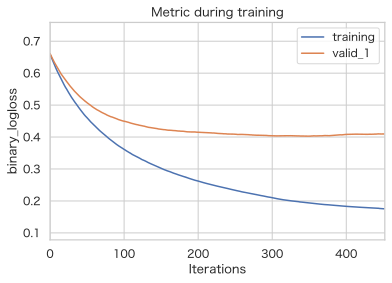

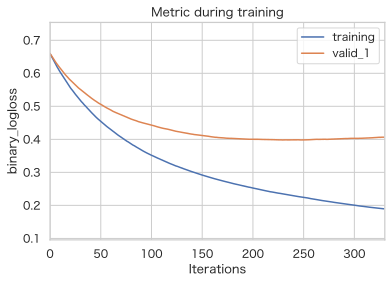

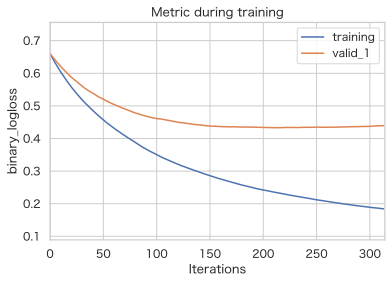

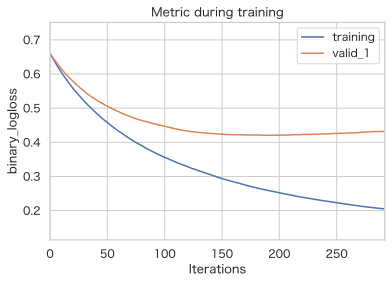

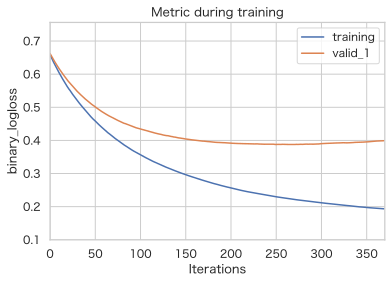

In [73]:
from sklearn.metrics import accuracy_score, log_loss


df_train: pd.DataFrame = pd.read_pickle(DF_DIR/'train.pkl')
best_params = read_pkl(path='best_params.pkl')

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'random_state': 42}


model = lgb.LGBMClassifier(**params, **best_params)

lgmbtrainer = LGBMTrainer(
    estimator=model,
    matrics=[accuracy_score, log_loss], 
    df=df_train, 
    target='Survived',
    use_shap=True)

lgmbtrainer.train()

In [74]:
df =lgmbtrainer.get_matrics()
df.mean()

train_accuracy_score      0.931541
val_accuracy_score        0.834995
train_log_loss            2.364486
val_log_loss              5.699136
best_iteration          251.600000
dtype: float64

In [60]:
lgmbtrainer.get_matrics()

train_accuracy_score  val_accuracy_score  train_log_loss  val_log_loss  best_iteration
0              0.908708            0.837989        3.153132      5.595708             100
1              0.914446            0.859551        2.954938      4.850983              98
2              0.913043            0.825843        3.003384      6.015212             100
3              0.920056            0.842697        2.761177      5.433106             100
4              0.903226            0.848315        3.342477      5.239059              99

In [85]:
shap_values, X_val = lgmbtrainer.get_shap_values()

shap.summary_plot(shap_values, X_val, alpha=0.9, show=False)
plt.savefig('shap1.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.close()

shap.summary_plot(shap_values, X_val, plot_type='bar', show=False)
plt.savefig('shap_bar.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.close()

In [31]:
df_test: pd.DataFrame = pd.read_pickle(DF_DIR/'test.pkl')
df_gender_submission: pd.DataFrame = pd.read_csv(DATA_DIR/'gender_submission.csv')

X_test = df_test.values

models = lgmbtrainer.get_models()
test_pred = np.zeros((len(X_test), len(models)))

for nfold, model in enumerate(models):
    _pred = model.predict(X_test)
    test_pred[:, nfold] = _pred

pred = np.where(np.mean(test_pred, axis=1) > 0.5, 1, 0)
df_gender_submission['Survived'] = pred

df_gender_submission.to_csv(DATA_DIR/'my_pred.csv', index=False)

In [10]:
a1 = np.array([
    [1, 2],
    [3, 4],
    [5, 6]
])

a2 = np.array([
    [10, 20],
    [30, 40],
    [50, 60]
])

ary = np.array([a1, a2])

ary.mean(axis=0)

array([[ 5.5, 11. ],
       [16.5, 22. ]])